# 0.) Import the Credit Card Fraud Data From CCLE

In [2]:
import pandas as pd
from google.colab import drive
import matplotlib.pyplot as plt
import numpy as np

In [3]:
drive.mount('/content/gdrive/', force_remount = True)

Mounted at /content/gdrive/


In [67]:
df = pd.read_csv("/content/gdrive/MyDrive/ECON441B/Week3/fraudTest.csv")

In [68]:
df.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2020-06-21 12:14:25,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,...,33.9659,-80.9355,333497,Mechanical engineer,1968-03-19,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0
1,1,2020-06-21 12:14:33,3573030041201292,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,...,40.3207,-110.4360,302,"Sales professional, IT",1990-01-17,324cc204407e99f51b0d6ca0055005e7,1371816873,39.450498,-109.960431,0
2,2,2020-06-21 12:14:53,3598215285024754,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,F,9333 Valentine Point,...,40.6729,-73.5365,34496,"Librarian, public",1970-10-21,c81755dbbbea9d5c77f094348a7579be,1371816893,40.495810,-74.196111,0
3,3,2020-06-21 12:15:15,3591919803438423,fraud_Haley Group,misc_pos,60.05,Brian,Williams,M,32941 Krystal Mill Apt. 552,...,28.5697,-80.8191,54767,Set designer,1987-07-25,2159175b9efe66dc301f149d3d5abf8c,1371816915,28.812398,-80.883061,0
4,4,2020-06-21 12:15:17,3526826139003047,fraud_Johnston-Casper,travel,3.19,Nathan,Massey,M,5783 Evan Roads Apt. 465,...,44.2529,-85.0170,1126,Furniture designer,1955-07-06,57ff021bd3f328f8738bb535c302a31b,1371816917,44.959148,-85.884734,0


# 1.) Use scikit learn preprocessing to split the data into 70/30 in out of sample

In [69]:
from sklearn.model_selection import train_test_split

In [70]:
df["trans_date_trans_time"] = pd.to_datetime(df["trans_date_trans_time"])
df["time_hour"] = [i.hour for i in df["trans_date_trans_time"]]
df["time_second"] = [i.second for i in df["trans_date_trans_time"]]

In [71]:
df_train, df_test = train_test_split(
  df, 
  train_size = 0.7,
  random_state = 425, # seed
  stratify = df.is_fraud
  )

In [72]:
X_train = pd.get_dummies(df_train[["category", "amt", "time_hour", "time_second"]],columns=["category"])
y_train = df_train.is_fraud
X_test = pd.get_dummies(df_test[["category", "amt", "time_hour", "time_second"]],columns=["category"])
y_test = df_test.is_fraud

# 2.) Make three sets of training data (Oversample, Undersample and SMOTE)

In [73]:
y_train.value_counts()

0    387502
1      1501
Name: is_fraud, dtype: int64

In [74]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

In [75]:
ros = RandomOverSampler(random_state = 0)
X_oversampled, y_oversampled = ros.fit_resample(X_train,y_train)

In [76]:
y_oversampled.value_counts()

0    387502
1    387502
Name: is_fraud, dtype: int64

In [77]:
rus = RandomUnderSampler(random_state = 0)
X_undersampled, y_undersampled = rus.fit_resample(X_train,y_train)

In [78]:
y_undersampled.value_counts()

0    1501
1    1501
Name: is_fraud, dtype: int64

In [79]:
from imblearn.over_sampling import SMOTE
resample = SMOTE()
X_smote, y_smote = resample.fit_resample(X_train,y_train)

In [80]:
y_smote.value_counts()

0    387502
1    387502
Name: is_fraud, dtype: int64

# 3.) Train three logistic regression models 

In [18]:
from sklearn.linear_model import LogisticRegression

In [25]:
model1 = LogisticRegression(max_iter=1000).fit(X_train, y_train)

In [26]:
model2 = LogisticRegression(max_iter=1000).fit(X_oversampled, y_oversampled)

In [27]:
model3 = LogisticRegression(max_iter=1000).fit(X_undersampled, y_undersampled)

In [28]:
model4 = LogisticRegression(max_iter=1000).fit(X_smote, y_smote)

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# 4.) Test the three models

In [29]:
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score

In [61]:
rg = pd.DataFrame(columns=['model','Test_auc','Test_acc', 'specificity'],index=[0,1,2,3])
rg.model = ['origin','oversample','undersample','SMOTE']

In [62]:
rg['Test_auc'][0] = roc_auc_score(
  y_test,
  model1.predict_proba(X_test)[:, 1]
  )

rg['Test_acc'][0] = accuracy_score(
  y_test, 
  model1.predict(X_test)
  )

cm = confusion_matrix(y_test, model1.predict(X_test))
rg['specificity'][0] = cm[1, 1] / (cm[1, 1] + cm[0, 1])

In [63]:
rg['Test_auc'][1] = roc_auc_score(
  y_test,
  model2.predict_proba(X_test)[:, 1]
  )

rg['Test_acc'][1] = accuracy_score(
  y_test, 
  model2.predict(X_test)
  )

cm = confusion_matrix(y_test, model2.predict(X_test))
rg['specificity'][1] = cm[1, 1] / (cm[1, 1] + cm[0, 1])

In [64]:
rg['Test_auc'][2] = roc_auc_score(
  y_test,
  model3.predict_proba(X_test)[:, 1]
  )

rg['Test_acc'][2] = accuracy_score(
  y_test, 
  model3.predict(X_test)
  )

cm = confusion_matrix(y_test, model3.predict(X_test))
rg['specificity'][2] = cm[1, 1] / (cm[1, 1] + cm[0, 1])

In [65]:
rg['Test_auc'][3] = roc_auc_score(
  y_test,
  model4.predict_proba(X_test)[:, 1]
  )

rg['Test_acc'][3] = accuracy_score(
  y_test, 
  model4.predict(X_test)
  )

cm = confusion_matrix(y_test, model4.predict(X_test))
rg['specificity'][3] = cm[1, 1] / (cm[1, 1] + cm[0, 1])

# 5.) Which performed best in Out of Sample metrics?

In [66]:
rg

,model,Test_auc,Test_acc,specificity
0,origin,0.811477,0.995861,0.0
1,oversample,0.907843,0.903687,0.029719
2,undersample,0.907204,0.907993,0.031499
3,SMOTE,0.898406,0.961563,0.071895


According to out of sample performance, using resampling methods can increase Test auc score. 

In case of auc score, oversampling seems to perform best in this daraset.

In case of specificity, SMOTE seems to perform best in this dataset.

# 6.) Pick two features and plot the two classes before and after SMOTE.

In [81]:
raw_temp = pd.concat([X_train, y_train],axis = 1)

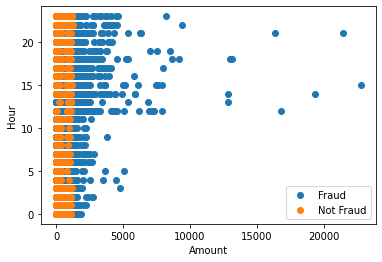

In [86]:
plt.scatter(raw_temp[raw_temp["is_fraud"]==0]["amt"], raw_temp[raw_temp["is_fraud"]==0]["time_hour"])
plt.scatter(raw_temp[raw_temp["is_fraud"]==1]["amt"], raw_temp[raw_temp["is_fraud"]==1]["time_hour"])
plt.legend(["Fraud","Not Fraud"])
plt.xlabel("Amount")
plt.ylabel("Hour")
plt.show()